In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
embeddings = np.load("data_full/embeddings_full.npy")
vocab = pickle.load(open("data_full/vocab.pkl",'rb'))

In [3]:
t_pos = pd.read_table("data_full/train_pos_full.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data_full/train_neg_full.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

In [4]:
def vectorize(tweets):
    vectorized_tweets_np = np.zeros((len(tweets),20))
    for i, tweet in enumerate(tweets):
        tweet_len = len(tweet.split(' '))
        tweet_embedding=np.zeros((tweet_len,20))
        for j, word in enumerate(tweet.split(' ')):
            if word not in vocab.keys():
                continue
            tweet_embedding[j] = embeddings[vocab.get(word)]
        vectorized_tweets_np[i] = tweet_embedding.mean(0)
    return vectorized_tweets_np

In [5]:
X = vectorize(df.tweet)
y = df['label'].values

In [6]:
X.shape

(2458295, 20)

In [7]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [8]:
class TestDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    
    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [10]:
train_data = TrainDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_data = TrainDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

In [11]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [19]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [20]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [21]:
model = nn.Sequential(nn.Linear(20, 40),
                        nn.ReLU(),
                        nn.Linear(40, 20),
                        nn.ReLU(),
                        nn.Linear(20, 2))

Epoch : 1



100%|██████████| 15365/15365 [00:43<00:00, 357.10it/s]


Train Error: 
 Accuracy: 59.7%, Avg loss: 0.660100 

Test Error: 
 Accuracy: 60.2%, Avg loss: 0.655113 

Epoch : 2



100%|██████████| 15365/15365 [00:40<00:00, 377.90it/s]


Train Error: 
 Accuracy: 60.3%, Avg loss: 0.653845 

Test Error: 
 Accuracy: 60.3%, Avg loss: 0.652801 

Epoch : 3



100%|██████████| 15365/15365 [00:39<00:00, 392.90it/s]


Train Error: 
 Accuracy: 60.4%, Avg loss: 0.652477 

Test Error: 
 Accuracy: 60.7%, Avg loss: 0.650947 

Epoch : 4



100%|██████████| 15365/15365 [00:39<00:00, 393.84it/s]


Train Error: 
 Accuracy: 60.5%, Avg loss: 0.651897 

Test Error: 
 Accuracy: 59.7%, Avg loss: 0.655935 

Epoch : 5



100%|██████████| 15365/15365 [00:42<00:00, 360.25it/s]


Train Error: 
 Accuracy: 60.5%, Avg loss: 0.651619 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.650219 

Epoch : 6



100%|██████████| 15365/15365 [00:39<00:00, 389.05it/s]


Train Error: 
 Accuracy: 60.5%, Avg loss: 0.651050 

Test Error: 
 Accuracy: 60.3%, Avg loss: 0.654138 

Epoch : 7



100%|██████████| 15365/15365 [00:37<00:00, 404.62it/s]


Train Error: 
 Accuracy: 60.5%, Avg loss: 0.650831 

Test Error: 
 Accuracy: 60.7%, Avg loss: 0.649500 

Epoch : 8



100%|██████████| 15365/15365 [00:38<00:00, 401.40it/s]


Train Error: 
 Accuracy: 60.6%, Avg loss: 0.650568 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.649721 

Epoch : 9



100%|██████████| 15365/15365 [00:40<00:00, 379.09it/s]


Train Error: 
 Accuracy: 60.6%, Avg loss: 0.650334 

Test Error: 
 Accuracy: 60.7%, Avg loss: 0.649410 

Epoch : 10



100%|██████████| 15365/15365 [00:39<00:00, 393.95it/s]


Train Error: 
 Accuracy: 60.6%, Avg loss: 0.650261 

Test Error: 
 Accuracy: 60.6%, Avg loss: 0.650416 



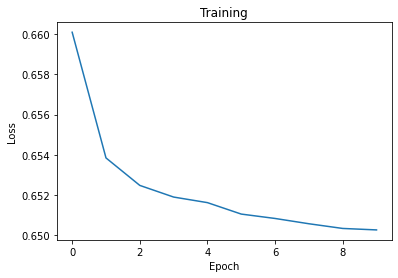

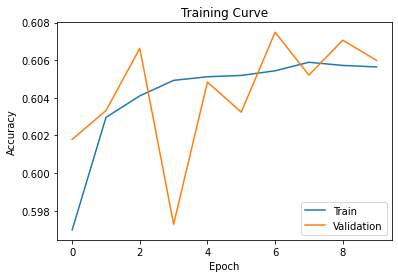

In [22]:
train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-2)

In [23]:
def prepare(tweet):
    tweet_len = len(tweet.split(' '))
    tweet_embedding=np.zeros((tweet_len,20))
    for j, word in enumerate(tweet.split(' ')):
        if word not in vocab.keys():
            continue
        tweet_embedding[j] = embeddings[vocab.get(word)]
    return tweet_embedding.mean(0)

In [28]:
torch.argmax(model(torch.FloatTensor(prepare("love"))))

tensor(1)